In [1]:
import os
import numpy as np
import tensorflow as tf

'''
import keras
from keras.layers import BatchNormalization, TimeDistributed
'''

import tensorflow.keras as keras
from tensorflow.python.keras.layers import BatchNormalization, TimeDistributed
from tensorflow.python.keras.utils import Sequence
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import backend as K


from modis_utils.generators import OneOutputGenerator
from modis_utils.misc import get_data_test, get_target_test, cache_data, restore_data
from modis_utils.model.core import compile_model, conv_lstm_2D, conv_2D
from modis_utils.model.loss_function import mse_with_mask, mse_with_mask_batch
from modis_utils.model.eval import predict_and_visualize_by_data_file_one_output
from tensorflow.python.keras import optimizers


Using TensorFlow backend.


In [1]:
def PSNRLoss(y_true, y_pred):
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

In [2]:
class MyGenerator(Sequence):
    def __init__(self, data_filenames, batch_size):
        self.data_filenames = data_filenames
        self.batch_size = batch_size

    def __len__(self):
        return len(self.data_filenames)
    
    def __getitem__(self, idx):         
        data = restore_data('output/{0}'.format(self.data_filenames[idx]))
        i = idx 
        batch_X = np.expand_dims(np.expand_dims(data[:-1,:,:], axis=0), axis=-1)
        batch_Y = np.expand_dims(np.expand_dims(data[-1,:,:], axis=0), axis=-1) 
        
        __max__ = 17.0
        __min__ = -34.0
        __range__ = __max__ - __min__
        
        X = (batch_X - __min__) / __range__
        Y = (batch_Y - __min__) / __range__
        
        return (X, Y)


listFile = os.listdir('output/')
nTrain = int(len(listFile) * 0.55)
nVal = int(len(listFile) * 0.35)
trainFiles = listFile[:nTrain]
valFiles = listFile[nTrain:nTrain+nVal]
testFiles = listFile[nTrain+nVal:]

trainGenerator = MyGenerator(trainFiles, 1)
valGenerator = MyGenerator(valFiles, 1)


input_timesteps = 12
img_height = 128
img_width = 128


opt = optimizers.Adam(lr=0.0001)
# opt = optimizers.SGD(lr=0.00005)

input_shape = (input_timesteps, img_height, img_width, 1)
compile_params = {'optimizer': opt, 'loss': 'mse', 'metrics': [PSNRLoss]}

# Model architecture
source = keras.Input(name='seed', shape=input_shape, dtype=tf.float32)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same')(source)
model = BatchNormalization()(model)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same')(model)
model = BatchNormalization()(model)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same')(model)
model = BatchNormalization()(model)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same')(model)
model = BatchNormalization()(model)
model = conv_lstm_2D(filters=64, kernel_size=3, strides=1,padding='same', return_sequences=False)(model)
model = BatchNormalization()(model)

predict_img = conv_2D(filters=1, kernel_size=3, strides=1,padding='same')(model)
model = keras.Model(inputs=[source], outputs=[predict_img])

model = compile_model(model, compile_params)
history = model.fit_generator( generator=trainGenerator, steps_per_epoch=nTrain, epochs=50, validation_data=valGenerator, validation_steps=2000)

In [4]:

model.save_weights('sgd_weights_final.h5', overwrite=True)
# 

Epoch 1/50
3080/3080 [==============================] - 4952s 2s/step - loss: 0.1582 - PSNRLoss: 8.6975 - val_loss: 0.0765 - val_PSNRLoss: 11.3207
Epoch 2/50
3080/3080 [==============================] - 4940s 2s/step - loss: 0.0776 - PSNRLoss: 11.2850 - val_loss: 0.0660 - val_PSNRLoss: 11.9060
Epoch 3/50
3080/3080 [==============================] - 4939s 2s/step - loss: 0.0565 - PSNRLoss: 12.6044 - val_loss: 0.0485 - val_PSNRLoss: 13.2281
Epoch 4/50
3080/3080 [==============================] - 4945s 2s/step - loss: 0.0482 - PSNRLoss: 13.3024 - val_loss: 0.0439 - val_PSNRLoss: 13.6830
Epoch 5/50
3080/3080 [==============================] - 4940s 2s/step - loss: 0.0411 - PSNRLoss: 13.9981 - val_loss: 0.0340 - val_PSNRLoss: 14.8073
Epoch 6/50
3080/3080 [==============================] - 4949s 2s/step - loss: 0.0351 - PSNRLoss: 14.6971 - val_loss: 0.0287 - val_PSNRLoss: 15.5029
Epoch 7/50
3080/3080 [==============================] - 4950s 2s/step - loss: 0.0317 - PSNRLoss: 15.1328 - val_lo

In [5]:
history.history.keys()

dict_keys(['val_loss', 'val_PSNRLoss', 'loss', 'PSNRLoss'])

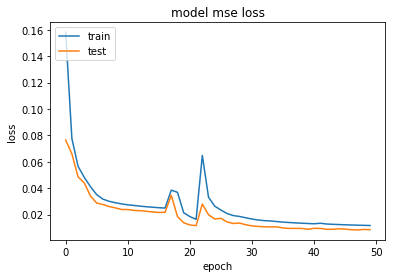

In [6]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mse loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

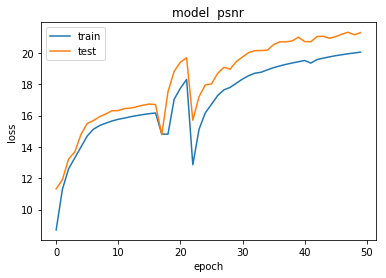

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['PSNRLoss'])
plt.plot(history.history['val_PSNRLoss'])
plt.title('model  psnr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()